#### Imports

In [1]:
import numpy as np
import pandas as pd
import scipy
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns

#### Loading data

In [2]:
cell_assignments = pd.read_csv('cell_assignments_filtered.csv')
region_assignments = pd.read_csv('concordex_cerebellum_res_2024-06-10.csv')
cereb_coords = np.load('cerebellum_coords_mat.npy')
cereb_counts = np.load('cerebellum_counts_mat.npy')
gene_labels = np.load('cerebellum_gene_labels.npy', allow_pickle=True)

cell_assignments = cell_assignments['first_type']
region_assignments = region_assignments['concordex_pred']

#### Preprocessing

In [ ]:
cereb_adata = ad.AnnData(cereb_counts)
cereb_adata.obs_names = ['Bead_'+str(i) for i in range(cereb_adata.n_obs)]
cereb_adata.var_names = gene_labels
cereb_adata.obs['cell_type'] = pd.Categorical(cell_assignments)
cereb_adata.obs['region'] = pd.Categorical(region_assignments)

# getting counts of how many genes are expressed and total mRNA reads in each cell
genes_expressed  = []
total_counts = []
X = cereb_adata.X
for bead_num in range(cereb_adata.n_obs):
    total_counts.append(np.sum(X[bead_num]))
    genes_expressed.append(np.count_nonzero(X[bead_num]))

cereb_adata.obs['n_genes_by_counts'] = genes_expressed
cereb_adata.obs['total_counts'] = total_counts



# getting counts of how many reads of each gene and cells expressing each gene
cells_expressing  = []
expressions = []
X = cereb_adata.X.T # transposes rows and columns so that genes are now rows
for gene_num in range(cereb_adata.n_vars):
    expressions.append(np.sum(X[gene_num]))
    cells_expressing.append(np.count_nonzero(X[gene_num]))

cereb_adata.var['n_cells_by_counts'] = cells_expressing
cereb_adata.var['total_counts'] = expressions

#### Cell focus

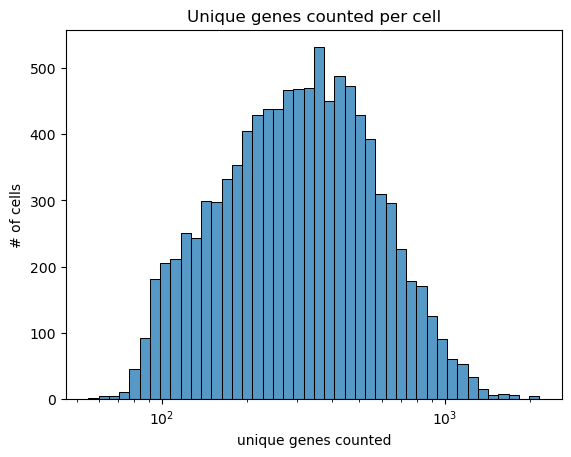

In [7]:
sns.histplot(cereb_adata.obs['n_genes_by_counts'], 
             log_scale=True).set(xlabel='unique genes counted', 
                                 ylabel='# of cells', 
                                 title='Unique genes counted per cell')
plt.show()

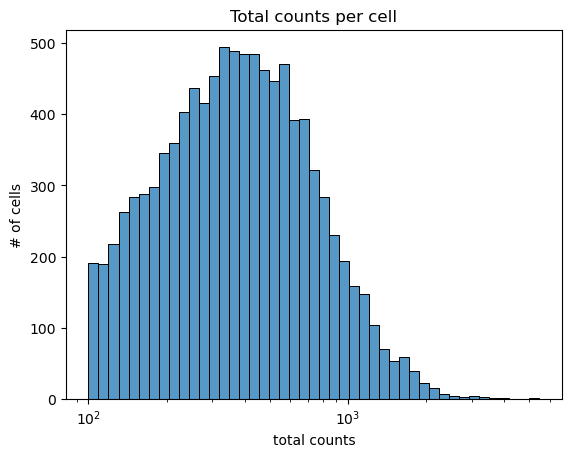

In [8]:
sns.histplot(cereb_adata.obs['total_counts'], 
            log_scale=True).set(xlabel='total counts', ylabel='# of cells', title='Total counts per cell')
plt.show()

#### Gene focus

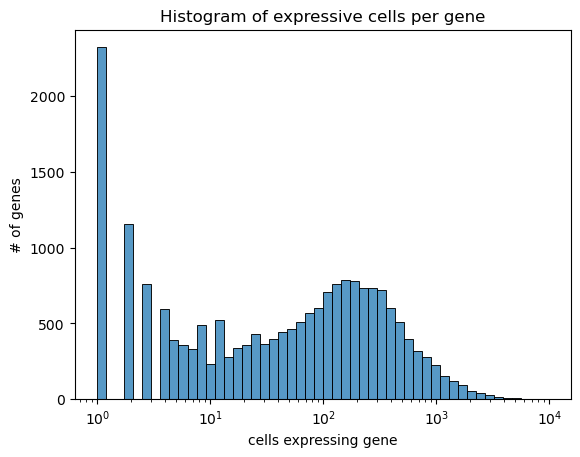

In [11]:
sns.histplot(cereb_adata.var['n_cells_by_counts'], 
            log_scale=True,
            bins=50).set(xlabel='cells expressing gene', 
                                ylabel='# of genes', 
                                title='Histogram of expressive cells per gene')

# plt.savefig('./cells_exprs.png', dpi=150, bbox_inches='tight')
plt.show()

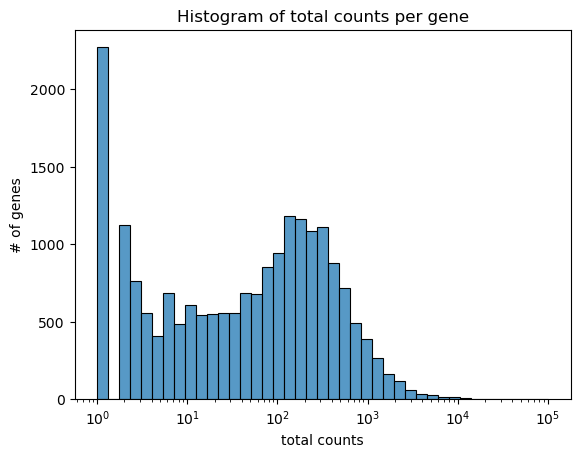

In [12]:
sns.histplot(cereb_adata.var['total_counts'], 
            log_scale=True,
            ).set(xlabel='total counts', 
                                ylabel='# of genes', 
                                title='Histogram of total counts per gene')

# plt.savefig('./total_counts.png', dpi=150, bbox_inches='tight')
plt.show()

#### Low expression genes

In [19]:
unexpressed = cereb_adata.var_names[cereb_adata.var['total_counts'] < 10]

ls = [gene+'\n' for gene in unexpressed]

with open('Low_expression_genes.txt', 'w') as f:
    f.writelines(ls)

#### Mitochondrial counts analysis

In [22]:
mt_genes = [i for i in range(14089, 14160)] + [i for i in range(23068, 23092)]
gene_labels[mt_genes]

array(['Mt1', 'Mt2', 'Mt3', 'Mt4', 'Mta1', 'Mta2', 'Mta3', 'Mtap',
       'Mtap7d3', 'Mtbp', 'Mtch1', 'Mtch2', 'Mtcl1', 'Mtcp1', 'Mtdh',
       'Mterf1a', 'Mterf1b', 'Mterf2', 'Mterf3', 'Mterf4', 'Mtf1', 'Mtf2',
       'Mtfmt', 'Mtfp1', 'Mtfr1', 'Mtfr1l', 'Mtfr2', 'Mtg1', 'Mtg2',
       'Mthfd1', 'Mthfd1l', 'Mthfd2', 'Mthfd2l', 'Mthfr', 'Mthfs',
       'Mthfsd', 'Mthfsl', 'Mtif2', 'Mtif3', 'Mtl5', 'Mtm1', 'Mtmr1',
       'Mtmr10', 'Mtmr11', 'Mtmr12', 'Mtmr14', 'Mtmr2', 'Mtmr3', 'Mtmr4',
       'Mtmr6', 'Mtmr7', 'Mtmr9', 'Mtnr1a', 'Mtnr1b', 'Mto1', 'Mtor',
       'Mtpap', 'Mtpn', 'Mtr', 'Mtrf1', 'Mtrf1l', 'Mtrr', 'Mtss1',
       'Mtss1l', 'Mttp', 'Mturn', 'Mtus1', 'Mtus2', 'Mtx1', 'Mtx2',
       'Mtx3', 'mt-Co1', 'mt-Co3', 'mt-Cytb', 'mt-Nd1', 'mt-Nd2',
       'mt-Nd3', 'mt-Nd4', 'mt-Nd5', 'mt-Nd6', 'mt-Rnr1', 'mt-Rnr2',
       'mt-Ta', 'mt-Tc', 'mt-Tf', 'mt-Ti', 'mt-Tl1', 'mt-Tl2', 'mt-Tm',
       'mt-Tp', 'mt-Tq', 'mt-Tr', 'mt-Ts2', 'mt-Tt', 'mt-Tv'],
      dtype=object)

In [23]:
# calculate percentage of MT genes counted for each cell
mt_counts = []
mt_pcts = []
X = cereb_adata.X
totals = list(cereb_adata.obs['total_counts'])
for bead_num in range(cereb_adata.n_obs):
    count = np.sum(X[bead_num][mt_genes])
    mt_counts.append(count)
    mt_pcts.append(count/totals[bead_num])

cereb_adata.obs['total_counts_mt'] = mt_counts
cereb_adata.obs['pct_counts_mt'] = mt_pcts
cereb_adata.obs

,cell_type,region,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
Bead_0,Bergmann,1,539,702,36,0.051282
Bead_1,Bergmann,0,388,511,48,0.093933
Bead_2,Fibroblast,2,210,264,23,0.087121
Bead_3,MLI2,3,121,133,8,0.060150
Bead_4,Granule,0,341,421,35,0.083135
...,...,...,...,...,...,...
Bead_9980,Oligodendrocytes,0,143,163,1,0.006135
Bead_9981,Bergmann,1,117,135,5,0.037037
Bead_9982,Granule,0,162,179,4,0.022346
Bead_9983,Oligodendrocytes,2,361,443,10,0.022573


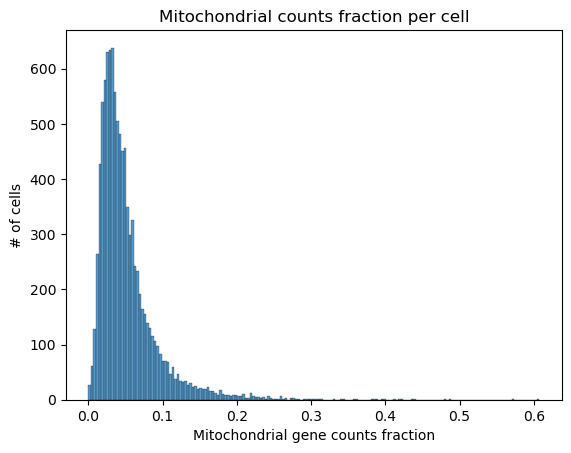

In [24]:
sns.histplot(cereb_adata.obs['pct_counts_mt'], 
            log_scale=False,
            ).set(xlabel='Mitochondrial gene counts fraction', 
                                ylabel='# of cells', 
                                title='Mitochondrial counts fraction per cell')

# plt.xlim(0, 0.3)
# plt.savefig('./mt_pcts.png', dpi=150, bbox_inches='tight')
plt.show()

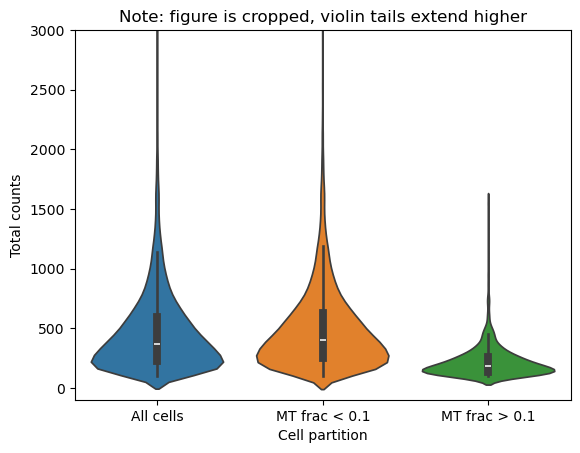

In [27]:
# violin plots for different statistics across partition groups
all_total_counts = cereb_adata.obs['total_counts'].rename('All cells')
mt_high_total_counts = cereb_adata.obs['total_counts'][cereb_adata.obs['pct_counts_mt'] > .1].rename('MT frac > 0.1')
mt_low_total_counts = cereb_adata.obs['total_counts'][cereb_adata.obs['pct_counts_mt'] < .1].rename('MT frac < 0.1')
df = pd.concat([all_total_counts, mt_low_total_counts, mt_high_total_counts], axis=1)

sns.violinplot(data=df, log_scale=False).set(xlabel='Cell partition', 
                                            ylabel='Total counts',
                                            title='Note: figure is cropped, violin tails extend higher')
plt.ylim((-100, 3000))
plt.show()

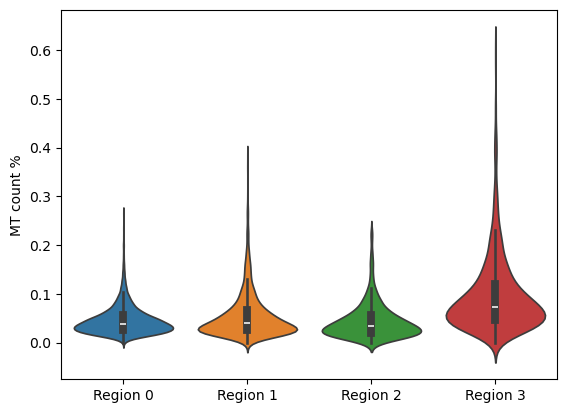

In [152]:
# regional MT percentage
region0 = cereb_adata.obs['pct_counts_mt'][cereb_adata.obs['region'] == 0].rename('Region 0')
region1 = cereb_adata.obs['pct_counts_mt'][cereb_adata.obs['region'] == 1].rename('Region 1')
region2 = cereb_adata.obs['pct_counts_mt'][cereb_adata.obs['region'] == 2].rename('Region 2')
region3 = cereb_adata.obs['pct_counts_mt'][cereb_adata.obs['region'] == 3].rename('Region 3')
df = pd.concat([region0, region1, region2, region3], axis=1)

sns.violinplot(data=df).set(ylabel='MT count %')
# plt.ylim((0, .4))
plt.show()

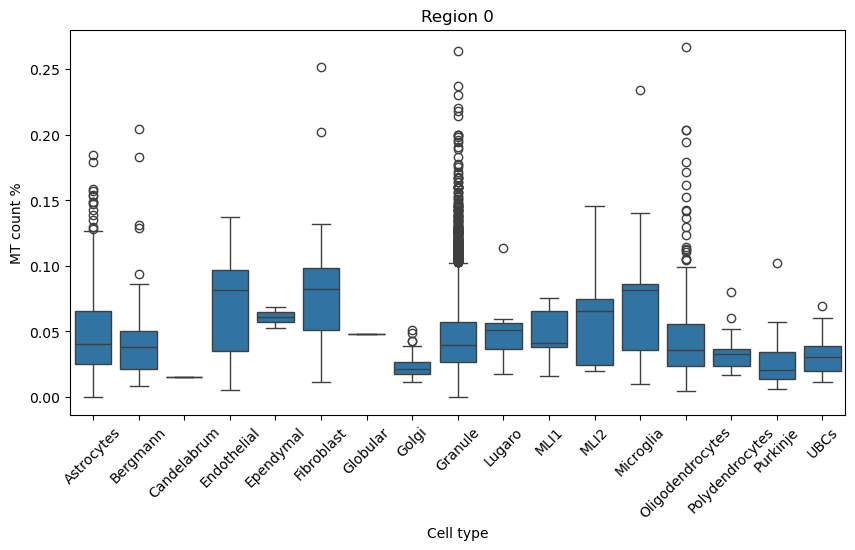

In [28]:
# MT percentages for cell type by region
reg = 0

regional_cells = cereb_adata.obs[['pct_counts_mt', 'cell_type']][cereb_adata.obs['region'] == reg] # get regional cells

fig, ax = plt.subplots(figsize=(10, 5)) # set figure size
order = [cat for cat in regional_cells['cell_type'].cat.categories if regional_cells['cell_type'].str.contains(cat).any()]

sns.boxplot(data=regional_cells, 
            x='cell_type', 
            y='pct_counts_mt', 
            ax=ax, 
            order=order).set(xlabel='Cell type', ylabel='MT count %', title='Region '+str(reg))
plt.xticks(rotation=45)
plt.show()